In [1]:
from pynq import Overlay, allocate
import pynq.lib.dma
from pynq import allocate


overlay = Overlay('./LSTM2.bit')  # 加载Overlay
dma = overlay.axi_dma_0  # 定义DMA对象

In [2]:
# import read_mnist as reader
# test_images = reader.load_images('data/t10k-images.idx3-ubyte')  # 读取测试集图片
# test_labels = reader.load_labels('data/t10k-labels.idx1-ubyte')  # 读取测试集标签
from time import sleep
import numpy as np

test_images1 = np.load('./gongxifacai2_x_test.npy')
test_labels = np.load('./gongxifacai2_y_test.npy')

test_images1 = np.array(test_images1,dtype=np.float32)
test_labels = np.array(test_labels,dtype=np.float32)


# input_buffer = allocate(shape=(203,784), dtype=np.float32)
test_images = allocate(shape=(203,784), dtype=np.float32)

for i in range(203):
    for j in range(784):
        test_images[i][j] = test_images1[i][j]

        

Image labels:  [0. 0. 4. 1. 4. 3. 4. 3.]


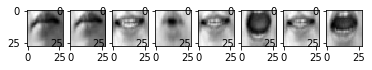

In [9]:
import random
import numpy as np
import matplotlib.pyplot as plt

IMG_NUM = 8

index = [0] * IMG_NUM
img = [0] * IMG_NUM
for i in range (IMG_NUM):
    index[i] = random.randint(0, 203)  # 在测试集中随机选取8张图片
    img_dat = np.array(test_images1[index[i]]).reshape(28, 28)

# 显示上面选取的8张测试图片
plt.figure()
for i in range (IMG_NUM):
    plt.subplot(1, IMG_NUM, i + 1)
    plt.imshow(np.array(test_images1[index[i]]).reshape(28, 28),cmap='gray')
print('Image labels: ', test_labels[index])
plt.show()

In [10]:
import time
import ctypes as ctyp

net = ctyp.CDLL('./liblstm.so')  # 加载RNN软件动态库

img_vec = (ctyp.c_float * (28 * 28))()
res_vec = (ctyp.c_float * 5)()

sw_time = [0] * IMG_NUM
for i in range (IMG_NUM):
    t0 = time.time()
    for j in range(28*28):  # 归一化
        img_vec[j] = test_images[index[i]][j] / 255
    ifr_res = net.infer(img_vec, res_vec)  # 调用软件RNN进行推导
    t1 = time.time()
    sw_time[i] = t1 - t0
    print('Result: %d,' % test_labels[index[i]], 'time: {:1.6f}s'.format(sw_time[i]))

Result: 0, time: 0.350501s
Result: 0, time: 0.341599s
Result: 4, time: 0.341066s
Result: 1, time: 0.341779s
Result: 4, time: 0.340531s
Result: 3, time: 0.342114s
Result: 4, time: 0.340761s
Result: 3, time: 0.340678s


In [11]:

# test_images = np.array(test_images)
# test_images = test_images.tolist()

hw_time = [0] * IMG_NUM
out_buf = allocate(shape=(10000, 10), dtype = np.float32)
for i in range (IMG_NUM):
    t0 = time.time()
    dma.sendchannel.transfer(test_images[index[i]])  # 调用DMA将待预测图片数据传输到IP核
    dma.recvchannel.transfer(out_buf[index[i]])  # 调用DMA从IP核获取RNN的推导结果
    dma.sendchannel.wait()  # 等待DMA发送完成
    dma.recvchannel.wait()  # 等待DMA接收完成
    sleep(0.12)

    out_list = np.array(out_buf[index[i]]).tolist()
    max_indx = out_list.index(max(out_list))  # 推导结果向量的最大分量的下标即为预测结果
#     sleep(0.02)
    t1 = time.time()
    hw_time[i] = t1 - t0
    print('Result: %d,' % test_labels[index[i]], 'time: {:1.6f}s'.format(hw_time[i]))
    
# 计算平均加速比
speed_up = [0.0] * IMG_NUM
for i in range (IMG_NUM):
    speed_up[i] = sw_time[i] / hw_time[i]
print('Average speedup: {:.3f}'.format(sum(speed_up) / IMG_NUM))

Result: 0, time: 0.125522s
Result: 0, time: 0.128256s
Result: 4, time: 0.127668s
Result: 1, time: 0.128341s
Result: 4, time: 0.127415s
Result: 3, time: 0.128060s
Result: 4, time: 0.127400s
Result: 3, time: 0.128065s
Average speedup: 2.684
